https://colab.research.google.com/drive/1h6hv0TxWQYUKUP2H2KCnWTGF7rQXPkGy?usp=sharing

<h2 style="text-align: center;"><b>Проект по курсу по «Школа DS»
</b></h2>
будет рассмотрена выборка по банкоматам ПАО Сбербанк, установленных в разных местах г.Москва 



## Цель проекта - найти наиболее подходящую модель ML для предсказания наиболее близкой по расположению по отношению к банкомату станции метро 


Загружаем все необходимые библиотеки

In [1]:
import pandas as pd
import pandas_profiling
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

Открываем склонированную папку

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/IldarVS/DS_study/main/Project/Map_US_2020_09_01_U.csv',sep =';')


Отображаем данные

In [3]:
df.head()

,code,roundTheClock,zone24,timeZone,workingHours,coordinates latitude,coordinates longitude,fullAddress,subwayStations,locationCategory,services,conditionCode
0,60026153,True,True,0,[],55.758824,37.752139,"г. Москва, ш. Энтузиастов, д. 31стр39","[['Шоссе Энтузиастов', 'ЖЕЛ', '50'], ['Шоссе Э...",Отделение банка,"{'CASHIN_ITEMS_CNT200': True, 'SELF_ENCASHMENT...",True
1,474707,False,False,0,"[[32400000, 64800000], None, [32400000, 648000...",55.658148,37.644300,"г. Москва, ш. Каширское, д. 23","[['Каширская', 'ЗЕЛ', '440']]",Медицинское учреждение,"{'QRCODE': True, 'SELF_ENCASHMENT': True, 'PAY...",True
2,10110756,False,False,0,"[[36000000, 72000000], None, [36000000, 720000...",55.672975,37.583526,"г. Москва, пр-кт Нахимовский, д. 24","[['Профсоюзная', 'ОРА', '1380'], ['Академическ...",Магазин,"{'QRCODE': True, 'CASHIN_ITEMS_CNT40': False, ...",False
3,698056,True,True,0,[],55.849964,37.451950,"г. Москва, ул. Свободы, д. 55","[['Сходненская', 'ФИО', '690']]",Отделение банка,"{'QRCODE': True, 'PAY_CASH': True, 'PAY_SERVIC...",True
4,60012941,True,True,0,[],55.723394,37.610437,"г. Москва, ул. Шаболовка, 10к2","[['Шаболовская', 'ОРА', '540'], ['Октябрьская'...",Отделение банка,"{'CASHIN_ITEMS_CNT200': True, 'QRCODE': True, ...",True


## Работа с признаками

#### Визуальный анализ

Изучим наши данные, какие признаки исходного датасета никак не повлияют на результат прогноза? Выбросим такие столбцы и отобразим результат.

In [4]:
df_1 = df.drop(columns=["code","roundTheClock",	"zone24",	"timeZone",	"workingHours", "locationCategory",	"services",	"conditionCode"])

In [5]:
df_1.head()

,coordinates latitude,coordinates longitude,fullAddress,subwayStations
0,55.758824,37.752139,"г. Москва, ш. Энтузиастов, д. 31стр39","[['Шоссе Энтузиастов', 'ЖЕЛ', '50'], ['Шоссе Э..."
1,55.658148,37.644300,"г. Москва, ш. Каширское, д. 23","[['Каширская', 'ЗЕЛ', '440']]"
2,55.672975,37.583526,"г. Москва, пр-кт Нахимовский, д. 24","[['Профсоюзная', 'ОРА', '1380'], ['Академическ..."
3,55.849964,37.451950,"г. Москва, ул. Свободы, д. 55","[['Сходненская', 'ФИО', '690']]"
4,55.723394,37.610437,"г. Москва, ул. Шаболовка, 10к2","[['Шаболовская', 'ОРА', '540'], ['Октябрьская'..."


Посмотрим на описательную статистику, которая суммирует центральную тенденцию, дисперсию и форму распределения набора данных. Корректно ли все заполнено?

In [6]:
df_1.describe()

,coordinates latitude,coordinates longitude
count,4916.000000,4916.000000
mean,55.738451,37.610343
std,0.086180,0.123390
min,55.492439,37.261705
25%,55.670274,37.524336
50%,55.742356,37.604456
75%,55.802209,37.696961
max,55.947644,37.931516


Создадим из  столбцов fullAddress	и subwayStations новые датасет спомощбю разбиения


fullAddress:

In [7]:
df_address = df_1["fullAddress"].str.split(",", expand=True)
df_address.head()

,0,1,2,3,4
0,г. Москва,ш. Энтузиастов,д. 31стр39,None,None
1,г. Москва,ш. Каширское,д. 23,None,None
2,г. Москва,пр-кт Нахимовский,д. 24,None,None
3,г. Москва,ул. Свободы,д. 55,None,None
4,г. Москва,ул. Шаболовка,10к2,None,None


Удалим не нужные столбцы

In [8]:
df_address_1 = df_address.drop(columns=[0,3,4]) 
df_address_1.head()

,1,2
0,ш. Энтузиастов,д. 31стр39
1,ш. Каширское,д. 23
2,пр-кт Нахимовский,д. 24
3,ул. Свободы,д. 55
4,ул. Шаболовка,10к2


Оставим в столбце 2 только номер дома, используя как **dataframe.str.replace** так и **re.sub**:


In [9]:
import re
df_address_1[2] = df_address_1[2].str.replace('(^\D+)|(\W+$)', '') 
for i in range(len(df_address_1[2])):
    if str(df_address_1[2][i]).isdigit() == False:
        try:
            df_address_1[2][i] = re.sub(r'(\d+$)', '', df_address_1[2][i])
        except:
            pass
df_address_1[2] = df_address_1[2].str.replace('(\D+$)', '') 
df_address_1.head()

,1,2
0,ш. Энтузиастов,31
1,ш. Каширское,23
2,пр-кт Нахимовский,24
3,ул. Свободы,55
4,ул. Шаболовка,10


Получившиеся столбцы добавим в наш DataSet

In [10]:
df_1 = df_1.assign(address=df_address_1[1])
df_1 = df_1.assign(dom=df_address_1[2])
df_1.head()

,coordinates latitude,coordinates longitude,fullAddress,subwayStations,address,dom
0,55.758824,37.752139,"г. Москва, ш. Энтузиастов, д. 31стр39","[['Шоссе Энтузиастов', 'ЖЕЛ', '50'], ['Шоссе Э...",ш. Энтузиастов,31
1,55.658148,37.644300,"г. Москва, ш. Каширское, д. 23","[['Каширская', 'ЗЕЛ', '440']]",ш. Каширское,23
2,55.672975,37.583526,"г. Москва, пр-кт Нахимовский, д. 24","[['Профсоюзная', 'ОРА', '1380'], ['Академическ...",пр-кт Нахимовский,24
3,55.849964,37.451950,"г. Москва, ул. Свободы, д. 55","[['Сходненская', 'ФИО', '690']]",ул. Свободы,55
4,55.723394,37.610437,"г. Москва, ул. Шаболовка, 10к2","[['Шаболовская', 'ОРА', '540'], ['Октябрьская'...",ул. Шаболовка,10


Теперь очистим столбец станций Метро:

In [11]:
df_metro = df_1["subwayStations"].str.split(",", expand=True)
df_metro = df_metro[0]
df_metro = df_metro.str.replace("'", "") 
df_metro= df_metro.str.replace("[", "") 
df_metro = df_metro.str.replace("]", "") 
df_metro.head()

0    Шоссе Энтузиастов
1            Каширская
2          Профсоюзная
3          Сходненская
4          Шаболовская
Name: 0, dtype: object

Получившийся столбец добавим в наш DataSet

In [12]:
df_1 = df_1.assign(subway=df_metro)
df_1.head()

,coordinates latitude,coordinates longitude,fullAddress,subwayStations,address,dom,subway
0,55.758824,37.752139,"г. Москва, ш. Энтузиастов, д. 31стр39","[['Шоссе Энтузиастов', 'ЖЕЛ', '50'], ['Шоссе Э...",ш. Энтузиастов,31,Шоссе Энтузиастов
1,55.658148,37.644300,"г. Москва, ш. Каширское, д. 23","[['Каширская', 'ЗЕЛ', '440']]",ш. Каширское,23,Каширская
2,55.672975,37.583526,"г. Москва, пр-кт Нахимовский, д. 24","[['Профсоюзная', 'ОРА', '1380'], ['Академическ...",пр-кт Нахимовский,24,Профсоюзная
3,55.849964,37.451950,"г. Москва, ул. Свободы, д. 55","[['Сходненская', 'ФИО', '690']]",ул. Свободы,55,Сходненская
4,55.723394,37.610437,"г. Москва, ул. Шаболовка, 10к2","[['Шаболовская', 'ОРА', '540'], ['Октябрьская'...",ул. Шаболовка,10,Шаболовская


Удалим 'грязные' столбцы  'fullAddress',	'subwayStations'

In [13]:
df_2 = df_1.drop(columns=['fullAddress',	'subwayStations'])
df_2.head()

,coordinates latitude,coordinates longitude,address,dom,subway
0,55.758824,37.752139,ш. Энтузиастов,31,Шоссе Энтузиастов
1,55.658148,37.644300,ш. Каширское,23,Каширская
2,55.672975,37.583526,пр-кт Нахимовский,24,Профсоюзная
3,55.849964,37.451950,ул. Свободы,55,Сходненская
4,55.723394,37.610437,ул. Шаболовка,10,Шаболовская


Проверим типы столбцов

In [14]:
df_2.dtypes

coordinates latitude     float64
coordinates longitude    float64
address                   object
dom                       object
subway                    object
dtype: object

Проверим заполненность столбцов не пустыми (не нулевыми) значениями 

In [15]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4916 entries, 0 to 4915
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   coordinates latitude   4916 non-null   float64
 1   coordinates longitude  4916 non-null   float64
 2   address                4916 non-null   object 
 3   dom                    4912 non-null   object 
 4   subway                 4916 non-null   object 
dtypes: float64(2), object(3)
memory usage: 192.2+ KB


Пустые ячейки метро заменим на "0" 

In [16]:
df_2.loc[df_2['subway'] == '', 'subway'] = '0'

Очистим выборку от строк с нулевыми (пустыми) значениями

In [17]:
df_2.dropna(inplace=True)

Проверим еще раз заполненность столбцов не пустыми (не нулевыми) значениями 

In [18]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4912 entries, 0 to 4915
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   coordinates latitude   4912 non-null   float64
 1   coordinates longitude  4912 non-null   float64
 2   address                4912 non-null   object 
 3   dom                    4912 non-null   object 
 4   subway                 4912 non-null   object 
dtypes: float64(2), object(3)
memory usage: 230.2+ KB


Посмотрим как сбалансированы наши классы, можно увидеть, что данные несбалансированны.


In [19]:
df_counts = df_2['subway'].value_counts()
print(df_counts)

0                       645
Братиславская            60
Люблино                  57
Отрадное                 57
Коломенская              54
                       ... 
Прокшино                  1
Сухаревская               1
Лесопарковая              1
Мичуринский Проспект      1
Соколиная Гора            1
Name: subway, Length: 220, dtype: int64


Прежде чем сбалансировать данные проведем encoding наших данных - переведем категориальные признаки в числовые

Добавим столбец № строки для индетификации каждой станции метро

In [20]:
df_2['number'] = np.arange(len(df_2))

#### Работа с категориальными признаками

категориальные признаки

Посмотрим на те колонки, в которых тип данных object (строка) и перекодируем их, воспользуемся кодом с занятия.

In [21]:
from sklearn import preprocessing

# Напишем функцию, которая принимает на вход DataFrame, кодирует числовыми значениями категориальные признаки
# и возвращает обновленный DataFrame и сами кодировщики.
def number_encode_features(init_df):
    result = init_df.copy() # копируем нашу исходную таблицу
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object: # np.object -- строковый тип / если тип столбца - строка, то нужно его закодировать
            encoders[column] = preprocessing.LabelEncoder() # для колонки column создаем кодировщик
            result[column] = encoders[column].fit_transform(result[column]) # применяем кодировщик к столбцу и перезаписываем столбец
    return result, encoders
# закодируем значения
encoded_data, encoders = number_encode_features(df_2) # Теперь encoded data содержит закодированные кат. признаки 


In [22]:
df_counts = encoded_data['subway'].value_counts()
print(df_counts)

0      645
27      60
121     57
90      57
65      54
      ... 
113      1
173      1
140      1
100      1
22       1
Name: subway, Length: 220, dtype: int64


In [23]:
encoded_data

,coordinates latitude,coordinates longitude,address,dom,subway,number
0,55.758824,37.752139,719,80,212,0
1,55.658148,37.644300,703,68,61,1
2,55.672975,37.583526,187,69,144,2
3,55.849964,37.451950,588,109,174,3
4,55.723394,37.610437,673,5,209,4
...,...,...,...,...,...,...
4911,55.597617,37.618812,362,71,188,4907
4912,55.774284,37.546219,716,44,15,4908
4913,55.655453,37.572010,396,73,0,4909
4914,55.794840,37.593158,629,103,154,4910


Создадим DataFrame для идентификации метро

In [24]:
encoded_data_subway = encoded_data.drop(columns=["coordinates latitude",	"coordinates longitude",	"address",	"dom"]) 
encoded_data =  encoded_data.drop(columns=["number"])

Выделим данные по метро, где нет значений в отдельный датафрейм, и удалим из основного Dataset 

In [25]:
encoded_data_metro =  encoded_data.loc[encoded_data['subway'] == 0]
encoded_data = encoded_data.drop(encoded_data.loc[encoded_data['subway'] == 0].index)
encoded_data_metro

,coordinates latitude,coordinates longitude,address,dom,subway
25,55.716747,37.387630,266,134,0
31,55.706494,37.930836,567,80,0
33,55.683153,37.926628,199,67,0
34,55.822979,37.526726,279,38,0
47,55.879354,37.715138,369,5,0
...,...,...,...,...,...
4896,55.905786,37.610889,53,1,0
4899,55.601872,37.468192,40,5,0
4902,55.766861,37.834237,587,54,0
4910,55.897016,37.632115,405,97,0


Добавим столбец **count** - для расчета количества выборок для станций метро

In [26]:
encoded_data['count'] = 1
encoded_data['count'] =encoded_data.groupby('subway').transform('count')
encoded_data = encoded_data.query("count > 3")

Удалим все строки со значением count < 3

In [27]:
encoded_data = encoded_data.drop(encoded_data.loc[encoded_data['count'] < 3].index)

Удалим столбец count

In [28]:
encoded_data = encoded_data.drop(columns=["count"])

In [29]:
df_counts = encoded_data['subway'].value_counts()
print(df_counts)

27     60
90     57
121    57
65     54
19     51
       ..
73      4
194     4
15      4
104     4
170     4
Name: subway, Length: 196, dtype: int64


In [30]:
encoded_data.head()

,coordinates latitude,coordinates longitude,address,dom,subway
0,55.758824,37.752139,719,80,212
1,55.658148,37.644300,703,68,61
2,55.672975,37.583526,187,69,144
3,55.849964,37.451950,588,109,174
4,55.723394,37.610437,673,5,209


Посмотрим визульно распределение поля subway

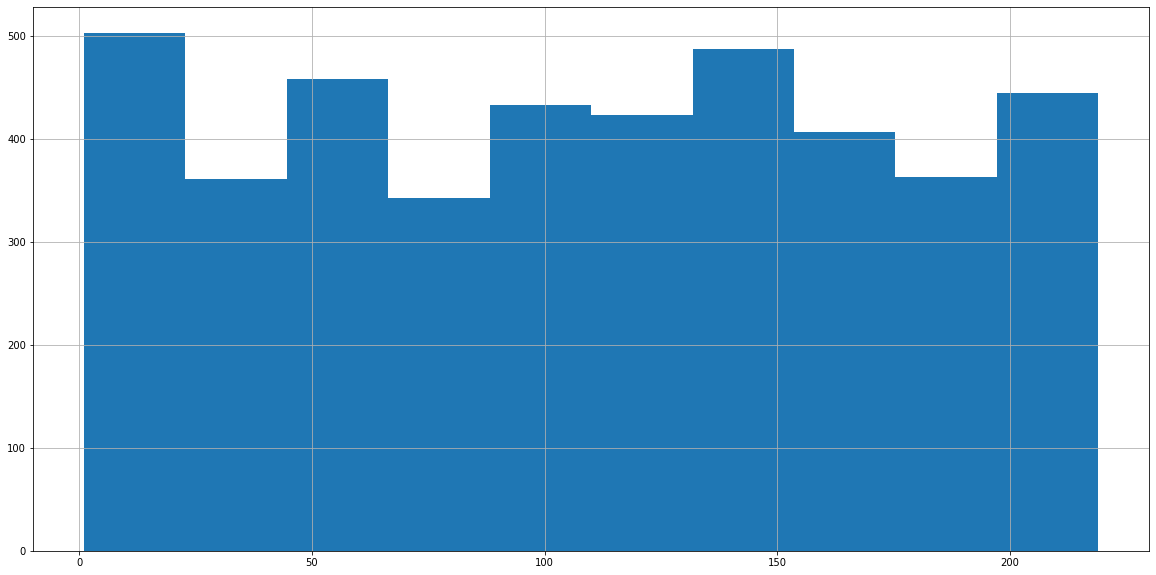

In [31]:
from matplotlib.pyplot import figure
figure(figsize = (20, 10))
encoded_data.subway.hist()

Посмотрим на описательную статистику

In [32]:
encoded_data.describe(percentiles=np.linspace(0, 1, 11))

,coordinates latitude,coordinates longitude,address,dom,subway
count,4224.000000,4224.000000,4224.000000,4224.000000,4224.000000
mean,55.736896,37.612431,376.143939,71.665009,109.116004
std,0.081730,0.116106,219.221871,39.747293,64.168680
min,55.524802,37.326654,1.000000,0.000000,1.000000
0%,55.524802,37.326654,1.000000,0.000000,1.000000
10%,55.627745,37.458534,81.000000,14.000000,19.000000
20%,55.656623,37.514324,174.000000,34.000000,44.000000
30%,55.686970,37.552633,193.000000,54.000000,65.000000
40%,55.717274,37.585129,292.000000,62.000000,90.000000
50%,55.741358,37.605579,377.000000,71.000000,110.000000


Посмотрим на распределение величин по признакам в наших данных

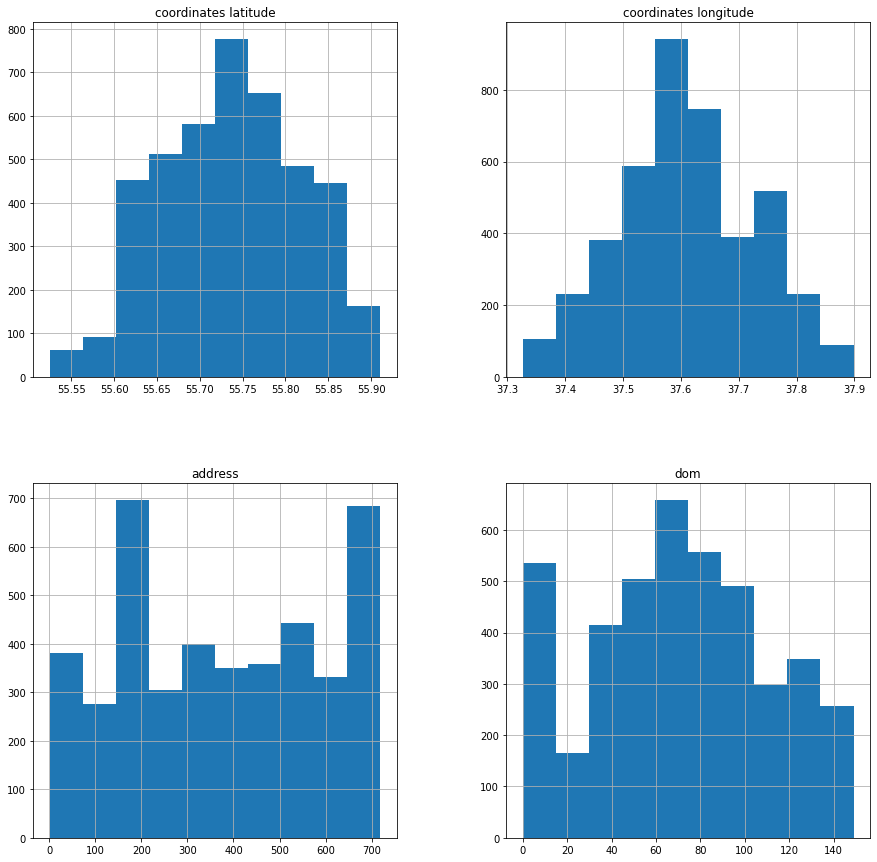

In [33]:
encoded_data_new = encoded_data.drop(['subway'], axis=1)
encoded_data_new.hist(figsize=(15,15))
plt.show()

Построим матрицу корреляций, если есть данные с единичной линейной зависимостью 

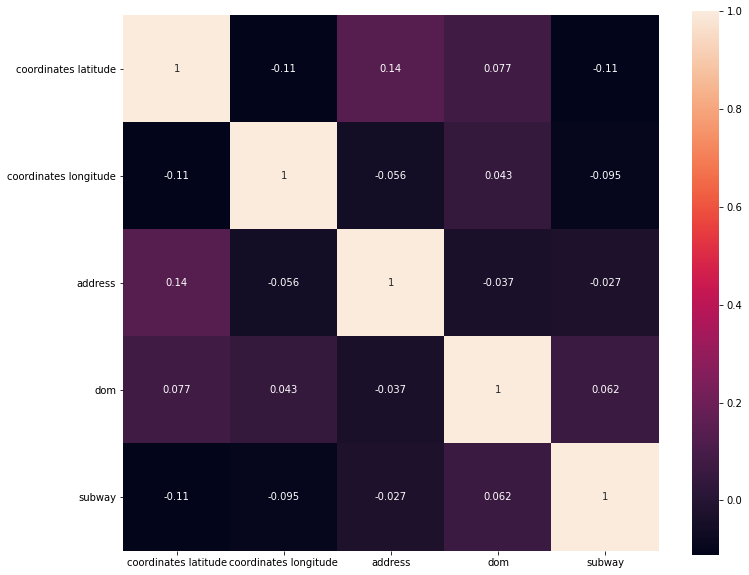

In [34]:
encoded_data_corr = encoded_data_new.corr()
plt.subplots(figsize=(12, 10))
sns.heatmap(encoded_data.corr(), square = True, annot=True)
plt.show()

In [35]:
# выбросим колонку, которую будем предсказывать
X, y = encoded_data[encoded_data.columns[0:4]].values, encoded_data[encoded_data.columns[4]].values


In [36]:
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

разделим на train test split

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [38]:
X_train[:5]

array([[ 55.873309,  37.664842, 372.      ,  75.      ],
       [ 55.664756,  37.4235  , 360.      ,  91.      ],
       [ 55.703499,  37.833866,  50.      ,  78.      ],
       [ 55.796834,  37.575733, 271.      ,  14.      ],
       [ 55.735707,  37.592303,   8.      ,  32.      ]])

In [39]:
y_train[:5]

array([ 10,  45,  81, 154, 125])

Еще раз посмотрим баланисровку нашей выборки, изменений не замечено

In [40]:
pd.Series(y_train).value_counts()

27     51
121    48
90     47
19     43
129    43
       ..
126     3
104     2
194     2
177     2
206     2
Length: 196, dtype: int64

Попробуем сбалансировать. Проведем аугементацию данных с помощью TomekLinks

In [41]:
from imblearn.under_sampling import TomekLinks
def undersample_data(X, y):
    return TomekLinks().fit_resample(np.array(X), np.array(y))

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [42]:
def augment_data(X, y):
    try:
        X, y = undersample_data(X, y)
    except:
        pass
    return X, y

In [43]:
X_train_augm2, y_train_augm2 = augment_data(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [44]:
X_train_augm2.shape, y_train_augm2.shape

((3269, 4), (3269,))

проверим баланс, несильно помогло

In [45]:
pd.Series(y_train_augm2).value_counts()

27     51
90     47
121    45
19     43
214    42
       ..
87      3
194     2
206     2
104     2
73      2
Length: 195, dtype: int64

Проведем аугементацию данных с помощью SMOTE

In [46]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(k_neighbors=1)

X_train_augm, y_train_augm = smote.fit_sample(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [47]:
pd.Series(y_train_augm).value_counts()

215    51
194    51
178    51
170    51
162    51
       ..
45     51
37     51
29     51
13     51
8      51
Length: 196, dtype: int64

Так выглядит более сбалансировано

###Попробуем использовать для машинного обучения Линейную регрессию

In [49]:
from sklearn.linear_model import LinearRegression
# линейный классификатор
regr = LinearRegression()

# обучаем
regr.fit(X_train_augm, y_train_augm)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [50]:
# получаем предсказания
y_regr = regr.predict(X_test)

Рассчитаем R2

In [51]:
metrics.r2_score(y_test, y_regr)

0.033821402189703975

Рассчитаем MAE

In [52]:
mae = metrics.mean_absolute_error(y_test, y_regr)
print( mae)

53.878506109973934


Результаты так себе - т.е наша выборка не подходит под линейную регрессию

###Регуляризация линейной регрессии

In [53]:
from sklearn.linear_model import Ridge, ElasticNet

ridge = Ridge(alpha=2, max_iter=1000, random_state=1)
ridge.fit(X_train_augm, y_train_augm)


print(metrics.r2_score(y_test, ridge.predict(X_test)))

0.03353237718473989


### SVR

In [54]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline

pipeline_svr = Pipeline(
    [('scalar1', StandardScaler()),
    ('lr_classifier', SVR(kernel='linear'))]
)

pipeline_svr.fit(X_train_augm, y_train_augm)
pipeline_svr.score(X_test, y_test)

0.019301305960399362

### Лес

In [138]:
from time import time
from sklearn.ensemble import RandomForestRegressor
time_rf = time()
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train_augm, y_train_augm)

time_rf = time() - time_rf


##R2

In [139]:
print(metrics.r2_score(y_test, rf_reg.predict(X_test)))

0.9824946182002181


In [140]:
y_forest = rf_reg.predict(X_test)

MAE

In [141]:
mae = metrics.mean_absolute_error(y_test, y_forest)
print( mae)

1.6375821862755267


####Случайный лес

In [59]:

from sklearn.model_selection import GridSearchCV
# перебираем глубину
# перебираем мин кол-во для разделения
# максимально кол-во признаков для более случайной выборки
param_grid = {
    'max_depth': [i for i in range(13, 15)],
    'min_samples_split': [i for i in range(2, 10)],
    'max_features': [2, len(X_train_augm)-1]
}

# инициализируем случайный лес с перебором по кросс-вал на выбранных выше праметрах
time_gs_rf = time()
gs_rfr = GridSearchCV(RandomForestRegressor(), param_grid, verbose=2, n_jobs=-1)
gs_rfr.fit(X_train_augm, y_train_augm)
time_gs_rf = time() - time_gs_rf
# best_params_ содержит в себе лучшие подобранные параметры, best_score_ лучшее качество
print(time_gs_rf)
gs_rfr.best_params_, gs_rfr.best_score_

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:   44.7s finished


45.45246696472168


({'max_depth': 14, 'max_features': 2, 'min_samples_split': 7},
 -0.705484272653874)

######R2


In [60]:
print(metrics.r2_score(y_test, gs_rfr.predict(X_test)))

0.8938568930423911


In [61]:
y_gs_rfr = gs_rfr.predict(X_test)

####MAE

In [62]:
mae = metrics.mean_absolute_error(y_test, y_gs_rfr)
print( mae)

10.437804544856277


Используем  классификатор kNN



Будем использовать модель k ближайших соседей

In [63]:
knn = KNeighborsClassifier()

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


gs1 {'n_neighbors': 1} 0.9227700850425213
gs2 {'n_neighbors': 1} 0.9146517367501674


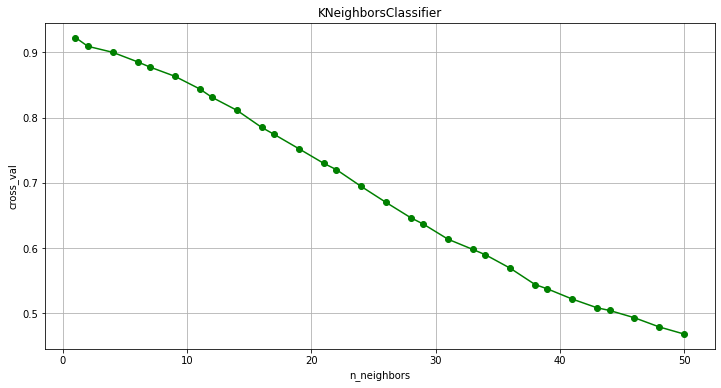

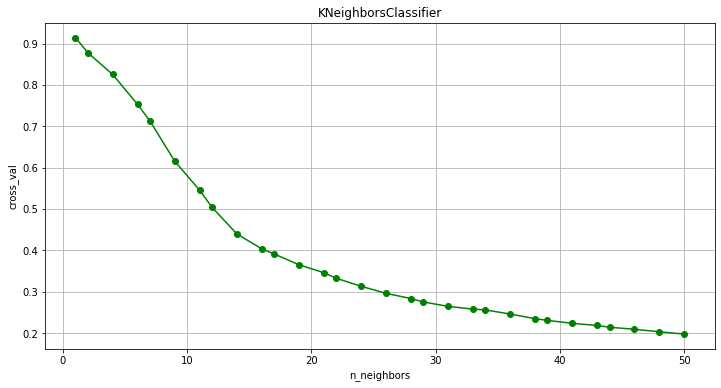

In [64]:
def grid_plot(x, y, x_label, title, y_label='cross_val'):
    plt.figure(figsize=(12, 6))
    plt.grid(True)
    plt.plot(x, y, 'go-')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
# Зададим сетку - среди каких значений выбирать наилучший параметр.
knn_grid = {'n_neighbors': np.array(np.linspace(1, 50, 30), dtype='int')} 

# Создаем объект кросс-валидации SMOTE
gs1 = GridSearchCV(knn, knn_grid, cv=5)
# Создаем объект кросс-валидации TomekLinks
gs2 = GridSearchCV(knn, knn_grid, cv=5)

# Обучаем его по выборке SMOTE
gs1.fit(X_train_augm, y_train_augm)
# Обучаем его по выборке TomekLinks
gs2.fit(X_train_augm2, y_train_augm2)
print("gs1",gs1.best_params_, gs1.best_score_)
print("gs2",gs2.best_params_, gs2.best_score_)
grid_plot(knn_grid['n_neighbors'], gs1.cv_results_['mean_test_score'], 'n_neighbors', 'KNeighborsClassifier')
grid_plot(knn_grid['n_neighbors'], gs2.cv_results_['mean_test_score'], 'n_neighbors', 'KNeighborsClassifier')

13.801106929779053
{'n_neighbors': 1} 0.9227700850425213


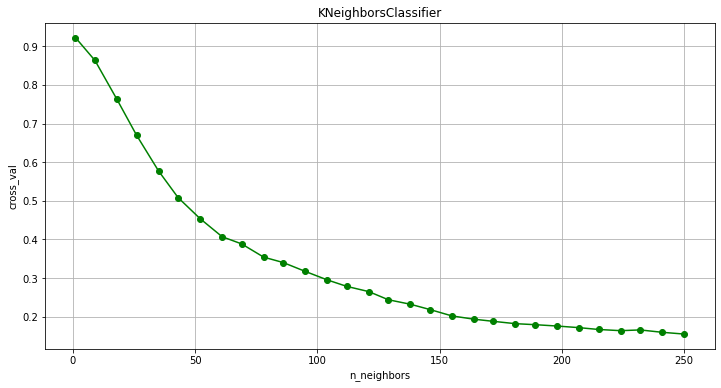

In [65]:
# Зададим сетку - среди каких значений выбирать наилучший параметр.
time_knn = time()
knn_grid = {'n_neighbors': np.array(np.linspace(1, 250, 30), dtype='int')} 

# Создаем объект кросс-валидации  и выбираем более лучший dataset (SMOTE)
gs = GridSearchCV(knn, knn_grid, cv=5)

# Обучаем его
gs.fit(X_train_augm, y_train_augm)
time_knn = time() - time_knn
print(time_knn)
print(gs.best_params_, gs.best_score_)
grid_plot(knn_grid['n_neighbors'], gs.cv_results_['mean_test_score'], 'n_neighbors', 'KNeighborsClassifier')

In [66]:
# импортируем и создаем knn классификатор по аналогии
knn = KNeighborsClassifier(n_neighbors=1) 
# тренируем для knn
clf_knn = knn.fit(X_train_augm, y_train_augm)
y_knn = clf_knn.predict(X_test)

In [67]:
print(metrics.classification_report(y_test, y_knn))

              precision    recall  f1-score   support

           1       1.00      0.90      0.95        10
           2       0.86      0.86      0.86         7
           3       0.60      1.00      0.75         3
           4       1.00      1.00      1.00         3
           5       0.91      1.00      0.95        10
           6       1.00      1.00      1.00        11
           7       1.00      1.00      1.00         1
           8       0.67      1.00      0.80         2
           9       0.86      1.00      0.92         6
          10       0.60      0.60      0.60         5
          11       1.00      1.00      1.00         2
          12       0.67      1.00      0.80         2
          13       1.00      0.67      0.80         3
          14       0.60      1.00      0.75         3
          17       1.00      0.88      0.93         8
          18       1.00      1.00      1.00         5
          19       1.00      0.88      0.93         8
          20       1.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Рассчитаем R2

In [68]:
metrics.r2_score(y_test, y_knn)

0.8197347634670803

Рассчитаем MAE

In [69]:
metrics.median_absolute_error(y_test, y_knn)

0.0

Проверим самую простую модель классификации Dummy

In [70]:
from sklearn import dummy
# тренируем для dummy
clf_mp = dummy.DummyClassifier("most_frequent").fit(X_train_augm, y_train_augm)
y_mp = clf_mp.predict(X_test)

In [71]:
print(metrics.classification_report(y_test, y_mp))

              precision    recall  f1-score   support

           1       0.01      1.00      0.02        10
           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        11
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         6
          10       0.00      0.00      0.00         5
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         3
          14       0.00      0.00      0.00         3
          17       0.00      0.00      0.00         8
          18       0.00      0.00      0.00         5
          19       0.00      0.00      0.00         8
          20       0.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Рассчитаем R2

In [72]:
metrics.r2_score(y_test, y_mp)

-2.9037454526078177

Рассчитаем MAE

In [73]:
metrics.median_absolute_error(y_test, y_mp)

109.0

##Используем логистическую регресию  и вычислим лучшие параметры с помощью  RandomizedSearchCV

In [74]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

In [75]:
alg = LogisticRegression()
distributions = dict(C=uniform(loc=0, scale=4), penalty=['l2', 'l1'])
clf = RandomizedSearchCV(alg, distributions, random_state=0)
param = clf.fit(X_train_augm, y_train_augm)
param.best_params_

{'C': 0.22685190926977272, 'penalty': 'l2'}

In [76]:
clf = LogisticRegression(C=0.22685190926977272,
                         penalty='l2')


In [77]:
clf.fit(X_train_augm, y_train_augm)
y_clf = clf.predict(X_test)

In [78]:
print(metrics.classification_report(y_test, y_clf))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00         3
           4       0.02      0.33      0.04         3
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        11
           7       0.08      1.00      0.15         1
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         6
          10       0.00      0.00      0.00         5
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         3
          14       0.00      0.00      0.00         3
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         0
          17       0.00      0.00      0.00         8
          18       0.00    

Рассчитаем значения R2

In [79]:
metrics.r2_score(y_test, y_clf)

-1.027219194139073

Рассчитаем MAE

In [80]:
metrics.median_absolute_error(y_test, y_clf)

67.0

#SVM с использованием RandomizedSearchCV

In [82]:
from sklearn.svm import SVC

In [83]:
algSVC = SVC()

distributions = dict(C=uniform(loc=0, scale=4))
clf = RandomizedSearchCV(algSVC, distributions, random_state=0)
clf.fit(X_train_augm , y_train_augm)
clf.best_params_

{'C': 3.854651042004117}

In [84]:
alg = SVC(C =  3.854651042004117)
alg.fit(X_train_augm , y_train_augm)
y_alg = alg.predict(X_test)

In [85]:
print(metrics.classification_report(y_test, y_alg))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        10
           2       0.38      0.43      0.40         7
           3       0.20      1.00      0.33         3
           4       0.03      0.33      0.05         3
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        11
           7       0.10      1.00      0.18         1
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         6
          10       0.00      0.00      0.00         5
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         3
          14       0.00      0.00      0.00         3
          16       0.00      0.00      0.00         0
          17       0.00      0.00      0.00         8
          18       0.00      0.00      0.00         5
          19       0.00    

Рассчитаем значения R2

In [86]:
metrics.r2_score(y_test, y_alg)

-0.9586941837922089

Рассчитаем MAE

In [87]:
metrics.median_absolute_error(y_test, y_alg)

61.0

Еще раз посмотрим на наш модифицированный датасет 

In [88]:
encoded_data.head()

,coordinates latitude,coordinates longitude,address,dom,subway
0,55.758824,37.752139,719,80,212
1,55.658148,37.644300,703,68,61
2,55.672975,37.583526,187,69,144
3,55.849964,37.451950,588,109,174
4,55.723394,37.610437,673,5,209


###Проверим с помощью One hot - значимость признаков

Создадим дата сет One hot

In [89]:
data_onehot = pd.get_dummies(encoded_data, columns=['dom'])

In [90]:
data_onehot.columns

Index(['coordinates latitude', 'coordinates longitude', 'address', 'subway',
       'dom_0', 'dom_1', 'dom_2', 'dom_3', 'dom_4', 'dom_5',
       ...
       'dom_140', 'dom_141', 'dom_142', 'dom_143', 'dom_144', 'dom_145',
       'dom_146', 'dom_147', 'dom_148', 'dom_149'],
      dtype='object', length=145)

In [91]:
data_onehot.dropna()

,coordinates latitude,coordinates longitude,address,subway,dom_0,dom_1,dom_2,dom_3,dom_4,dom_5,dom_6,dom_7,dom_8,dom_9,dom_10,dom_11,dom_12,dom_13,dom_14,dom_15,dom_16,dom_17,dom_18,dom_20,dom_21,dom_22,dom_23,dom_24,dom_25,dom_26,dom_27,dom_28,dom_29,dom_30,dom_31,dom_32,dom_34,dom_35,dom_37,dom_38,...,dom_109,dom_110,dom_111,dom_112,dom_113,dom_114,dom_115,dom_117,dom_118,dom_119,dom_120,dom_121,dom_122,dom_123,dom_124,dom_125,dom_126,dom_127,dom_128,dom_129,dom_130,dom_131,dom_132,dom_133,dom_134,dom_135,dom_136,dom_137,dom_138,dom_139,dom_140,dom_141,dom_142,dom_143,dom_144,dom_145,dom_146,dom_147,dom_148,dom_149
0,55.758824,37.752139,719,212,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,55.658148,37.644300,703,61,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,55.672975,37.583526,187,144,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,55.849964,37.451950,588,174,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,55.723394,37.610437,673,209,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4909,55.642253,37.771985,252,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4911,55.597617,37.618812,362,188,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4912,55.774284,37.546219,716,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4914,55.794840,37.593158,629,154,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [92]:
#data_onehot = data_onehot.reset_index()
from sklearn.model_selection import train_test_split
data_onehot.fillna(0, inplace=True)
X = data_onehot.drop(['subway'], axis=1)
y = data_onehot['subway']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
#y_train = y_train.values.astype(np.float)

#### 1 цифра на признак

## Алгоритмы

In [93]:
X_train.head()

,coordinates latitude,coordinates longitude,address,dom_0,dom_1,dom_2,dom_3,dom_4,dom_5,dom_6,dom_7,dom_8,dom_9,dom_10,dom_11,dom_12,dom_13,dom_14,dom_15,dom_16,dom_17,dom_18,dom_20,dom_21,dom_22,dom_23,dom_24,dom_25,dom_26,dom_27,dom_28,dom_29,dom_30,dom_31,dom_32,dom_34,dom_35,dom_37,dom_38,dom_39,...,dom_109,dom_110,dom_111,dom_112,dom_113,dom_114,dom_115,dom_117,dom_118,dom_119,dom_120,dom_121,dom_122,dom_123,dom_124,dom_125,dom_126,dom_127,dom_128,dom_129,dom_130,dom_131,dom_132,dom_133,dom_134,dom_135,dom_136,dom_137,dom_138,dom_139,dom_140,dom_141,dom_142,dom_143,dom_144,dom_145,dom_146,dom_147,dom_148,dom_149
4455,55.768972,37.580104,281,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4222,55.743153,37.670703,280,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1693,55.596040,37.593785,250,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4051,55.655620,37.743902,447,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1432,55.796395,37.800712,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


####Проверим значимость признаков используя случайный лес регрессии

In [94]:
from sklearn.model_selection import GridSearchCV
# перебираем глубину
# перебираем мин кол-во для разделения
# максимально кол-во признаков для более случайной выборки
param_grid = {
    'max_depth': [i for i in range(13, 15)],
    'min_samples_split': [i for i in range(2, 10)],
    'max_features': [2, len(X_train)-1]
}

# инициализируем случайный лес с перебором по кросс-вал на выбранных выше праметрах
gs = GridSearchCV(RandomForestRegressor(), param_grid, verbose=2, n_jobs=-1)
gs.fit(X_train, y_train)

# best_params_ содержит в себе лучшие подобранные параметры, best_score_ лучшее качество
print()
gs.best_params_, gs.best_score_

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.6s


[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:   15.8s finished


({'max_depth': 14, 'max_features': 2, 'min_samples_split': 3},
 0.19096139824923786)

In [95]:
column_names = list(data_onehot.columns)
del column_names[1]

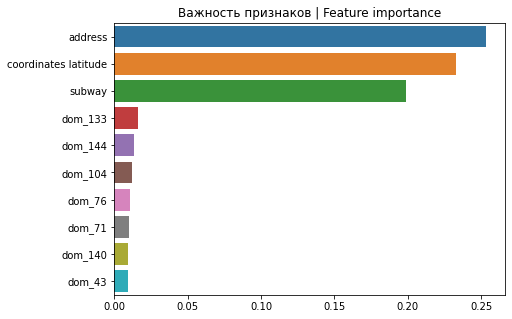

In [96]:
def plot_feature_importances(model, columns):
    # выбираем кол-во признаков для отображения
    nr_f = 10
    # берем данные для графика
    # берем алгоритм с лучшими параметрами
    # по х мы берем важность признаков исходя из критерия Джини, сортируем их вместе с названиями колонок по возрастанию
    imp = pd.Series(data = model.best_estimator_.feature_importances_, 
                    index=columns).sort_values(ascending=False)
    # построили фигуру
    plt.figure(figsize=(7,5))
    # отобразили название
    plt.title("Важность признаков | Feature importance")
    # построили 10 самых важных признаков
    ax = sns.barplot(y=imp.index[:nr_f], x=imp.values[:nr_f], orient='h')


# вызвали функцию отображения самых важных признаков
# тут columns - название всех колонок, типа encoded_df.columns
plot_feature_importances(gs, column_names)

###Теперь посмотрим как  проведут обучение различные бустинги

Восстановим train

In [97]:
X, y = encoded_data[encoded_data.columns[0:4]].values, encoded_data[encoded_data.columns[4]].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [98]:
!pip install catboost

####CATBOOST классификация

In [99]:
# catboost for classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from matplotlib import pyplot
time_model_class = time()
model_class = CatBoostClassifier(verbose=0, n_estimators=100)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model_class, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
model_class = CatBoostClassifier(verbose=0, n_estimators=100)
model_class.fit(X_train, y_train)
yhat = model_class.predict(X_test)
print('Prediction: %d' % yhat[0])
time_model_class = time() - time_model_class

Accuracy: 0.941 (0.014)
Prediction: 132


In [101]:
# catboost for regression
from catboost import CatBoostRegressor
from sklearn.model_selection import RepeatedKFold
model_reg = CatBoostRegressor(verbose=0, n_estimators=100)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model_reg, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
model_reg = CatBoostRegressor(verbose=0, n_estimators=100)
model_reg.fit(X_train, y_train)
yhat = model_reg.predict(X_test)
print('Prediction: %.3f' % yhat[0])

MAE: -20.006 (1.200)
Prediction: 104.318


In [112]:
# gradient boosting for classification in scikit-learn
from sklearn.ensemble import GradientBoostingClassifier
# evaluate the model
time_gb_class = time()
model_gb_class = GradientBoostingClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model_gb_class, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
model_gb_class= GradientBoostingClassifier()
model_gb_class.fit(X_train, y_train)
# make a single prediction
yhat = model_gb_class.predict(X_test)
print('Prediction: %d' % yhat[0])
time_gb_class = time() - time_gb_class

Accuracy: 0.875 (0.139)
Prediction: 132


In [103]:
from sklearn.ensemble import GradientBoostingRegressor
# evaluate the model
model_gb_reg = GradientBoostingRegressor()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model_gb_reg, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
model_gb_reg = GradientBoostingRegressor()
model_gb_reg.fit(X_train, y_train)
# make a single prediction
yhat = model_gb_reg.predict(X_test)
print('Prediction: %.3f' % yhat[0])


MAE: -35.969 (1.453)
Prediction: 81.136


In [104]:
# histogram-based gradient boosting for classification in scikit-learn
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
# evaluate the model
time_hbgb = time()
model_hbgb = HistGradientBoostingClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model_hbgb, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
model_hbgb = HistGradientBoostingClassifier()
model_hbgb.fit(X_train, y_train)
# make a single prediction
yhat = model_hbgb.predict(X_test)
print('Prediction: %d' % yhat[0])
time_hbgb = time() - time_hbgb

Accuracy: 0.017 (0.008)
Prediction: 117


In [105]:
# histogram-based gradient boosting for regression in scikit-learn
from sklearn.ensemble import HistGradientBoostingRegressor
# evaluate the model
model_hgbr = HistGradientBoostingRegressor()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model_hgbr,  X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
model_hgbr = HistGradientBoostingRegressor()
model_hgbr.fit( X_train, y_train,)
# make a single prediction
row = [[2.02220122, 0.31563495, 0.82797464, -0.30620401, 0.16003707, -1.44411381, 0.87616892, -0.50446586, 0.23009474, 0.76201118]]
yhat = model_hgbr.predict(X_test)
print('Prediction: %.3f' % yhat[0])

MAE: -14.706 (1.213)
Prediction: 113.132


In [106]:
!pip install xgboost

In [107]:
# xgboost for classification
from numpy import asarray
from xgboost import XGBClassifier
# evaluate the model
time_XGBC = time()
model_XGBC = XGBClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model_XGBC, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
model_XGBC = XGBClassifier()
model_XGBC.fit(X_train, y_train)
yhat = model_XGBC.predict(X_test)
print('Prediction: %d' % yhat[0])
time_XGBC = time() - time_XGBC

Accuracy: 0.954 (0.009)
Prediction: 132


In [108]:
# xgboost for regression
from xgboost import XGBRegressor
# evaluate the model
model_XGBR = XGBRegressor(objective='reg:squarederror')
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model_XGBR, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
model_XGBR = XGBRegressor(objective='reg:squarederror')
model_XGBR.fit(X_train, y_train)
yhat = model_XGBR.predict(X_test)
print('Prediction: %.3f' % yhat[0])


MAE: -36.063 (1.572)
Prediction: 85.851


In [109]:
!pip install lightgbm

In [110]:
# lightgbm for classification
from lightgbm import LGBMClassifier
# evaluate the model
time_LGBMC = time()
model_LGBMC = LGBMClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model_LGBMC, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
model_LGBMC = LGBMClassifier()
model_LGBMC.fit(X_train, y_train)
yhat = model_LGBMC.predict(X_test)
print('Prediction: %d' % yhat[0])
time_LGBMC = time() - time_LGBMC

Accuracy: 0.952 (0.010)
Prediction: 132


In [111]:
# lightgbm for regression
from lightgbm import LGBMRegressor
model_LGBMR = LGBMRegressor()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model_LGBMR,  X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
model_LGBMR = LGBMRegressor()
model_LGBMR.fit( X_train, y_train)
yhat = model_LGBMR.predict(X_test)
print('Prediction: %.3f' % yhat[0])

MAE: -14.760 (1.112)
Prediction: 116.124


Проверим все данные по Моделям

Сделаем проверку на DataSet сформированного на данных не имеющих в выборке названия Метро

In [145]:
from random import randint
encoded_data_metro
X_search_full = encoded_data_metro[encoded_data_metro.columns[0:4]].values
#X_search_full
X_search = X_search_full[randint(0,len(X_search_full-1))]
X_search

array([ 55.880299,  37.694748, 454.      , 124.      ])

Посмотрим где находится рассчитанная станция метро

In [146]:
def proverka_model(model, name, X_search, t):
    y_search = model.predict([X_search])
    print(y_search)
    try:
        y_search = int(y_search[0])
        df_r = encoded_data.loc[encoded_data['subway'] == y_search]
    except:
        df_r = encoded_data.loc[encoded_data['subway'] == y_search[0][0]]
    n_metro = encoded_data_subway.loc[encoded_data_subway['subway'] == df_r['subway'].iloc[0]] 
    name_metro = df_2.loc[df_2['number']  == n_metro['number'].iloc[0]]
    print(f"По расчету '{name}' ближайшая станция метро '{name_metro['subway'].iloc[0]}' для банкомата расположенного на широте и долготе: {X_search[0]}, {X_search[1]}, время формирования модели {round(t,2)}") 

proverka_model(clf_knn, "KNN", X_search, time_knn)
proverka_model(model_class, "CatBoost", X_search,time_model_class)
proverka_model(model_gb_class, "GradientBoosting", X_search, time_gb_class)
proverka_model(model_hbgb, "histogram-based gradient boosting", X_search, time_hbgb)
proverka_model(model_XGBC, "xgboost", X_search, time_XGBC)
proverka_model(model_LGBMC, "lightgbm", X_search, time_LGBMC)
proverka_model(rf_reg, "Forest", X_search, time_rf)
proverka_model(gs_rfr, "Random_Forest", X_search, time_gs_rf)


[182]
По расчету 'KNN' ближайшая станция метро 'Тульская' для банкомата расположенного на широте и долготе: 55.880299, 37.694748, время формирования модели 13.8
[[10]]
По расчету 'CatBoost' ближайшая станция метро 'Бабушкинская' для банкомата расположенного на широте и долготе: 55.880299, 37.694748, время формирования модели 905.05
[10]
По расчету 'GradientBoosting' ближайшая станция метро 'Бабушкинская' для банкомата расположенного на широте и долготе: 55.880299, 37.694748, время формирования модели 6534.01
[191]
По расчету 'histogram-based gradient boosting' ближайшая станция метро 'Улица Скобелевская' для банкомата расположенного на широте и долготе: 55.880299, 37.694748, время формирования модели 151.55
[10]
По расчету 'xgboost' ближайшая станция метро 'Бабушкинская' для банкомата расположенного на широте и долготе: 55.880299, 37.694748, время формирования модели 480.57
[10]
По расчету 'lightgbm' ближайшая станция метро 'Бабушкинская' для банкомата расположенного на широте и долгот